In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from tsmoothie.smoother import ConvolutionSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGMM
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering as hier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
warnings.filterwarnings('ignore')

import nbimporter
import Functions as Fu


In [2]:
# Φτιαχνω τα objects 

bus1 = Fu.Bus("Sub1act_630.xlsx","Sub1react_630.xlsx")
bus2 = Fu.Bus("Sub2act_630.xlsx","Sub2react_630.xlsx")
bus3 = Fu.Bus("Sub3act_630.xlsx","Sub3react_630.xlsx")

Διάβασμα αρχείων excel και δημιουργία τριών classes Bus

In [3]:
Buses = [bus1,bus2,bus3]
busnames = [('bus1act','bus1react'), ('bus2act','bus2react'), ('bus3act','bus3react')]
powernames = ['real','react']
start = dt.datetime(2018,1,1)
end = dt.datetime(2019,1,1)

#All buses in a dataframe called buses
buses = pd.DataFrame()

for index,bus in enumerate(Buses):
    real = bus.real['Value']
    react = bus.react['Value']

    buses[busnames[index][0]] = real
    buses[busnames[index][1]] = react

# 1. Προεργασία δεδομένων

In [4]:
# Dhmioyrgia dictionary me keys ta columns tou buses kai adeia values opou 8a apothikeusw ta labels
labels_dic = {key: None for key in buses.columns}
filtered_data = {key: None for key in buses.columns}

for key in buses.columns:
    labels_dic[key] = Fu.visualization(buses[key], days=365, n_components=12, title = key)
    
#Αντικατάσταση extreme points με βαση zscore ανα ωρα και ξανά οπτικοποίηση τους
for key in buses.columns:
    filtered_data[key] = Fu.without_extreme_outliers(data = buses[key], labels=labels_dic[key])
    
#Αντικατάσταση πραγματικών τιμών με  filtered_data   
for key in buses.columns:    
    buses[key] = filtered_data[key].reshape(-1).round(2)
for index,bus in enumerate(Buses):
    bus.real['Value'] = buses[busnames[index][0]]
    bus.react['Value'] = buses[busnames[index][1]]

# 2.2 Generating ανά εποχή με gmm και Markov chains:
1) Χωρισμός σε εργάσιμες και ΣΚ. 2) Χωρισμός σε clusters και Markov chain ανάλυση πραγματικών δεδομένων 4) 150 samples ανά cluster 5) Με βάση τον transition matrix πίνακα εξομοίωση μιας ολόκληρης εποχής 6) Απ τα samples που δημιουργήθηκαν, επιλογή με βάση την εξομοίωση

In [5]:
index = pd.date_range(start=start, end=end, freq='15min', closed='left')
genbuses_2_2 = pd.DataFrame(index = index)

seasons = ['winter','spring','summer','fall']
Months = {}

for index,bus in enumerate(Buses):
    for index2,power in enumerate(powernames):
        
        #Για καθε εποχη κανω GMM δειγαμτοληψια, 5clusters για καθημερινες, 2 για ΣΚ, απο 200 δειγματα για ΣΚ και WD αντιστοιχα 
        for season in seasons:    
            data, months = bus.season(season=season, power=power)
            Year2_2 = Fu.generate_season_2_2(data=data, season=season, months=months, dict_months=Months)
        #Ενωνω τους μηνες απο το dict months 
        months = np.arange(12)+1
        year = Fu.concatinate_season(Months, months)
        data = year.reshape(-1).tolist()
        
        genbuses_2_2[busnames[index][index2]] = data

for column in genbuses_2_2.columns:
    if min(genbuses_2_2[column])<=0:
        days = Fu.unique([(i.day,i.month) for i in pd.DataFrame(genbuses_2_2[column].loc[genbuses_2_2[column]<=0]).index])
        for j in days:
            minimum = min(genbuses_2_2[column].loc[(genbuses_2_2.index.day==j[0]) & (genbuses_2_2.index.month==j[1])])
            genbuses_2_2[column].loc[(genbuses_2_2.index.day==j[0]) & (genbuses_2_2.index.month==j[1])] += abs(minimum)
            
genbuses_2_2

,bus1act,bus1react,bus2act,bus2react,bus3act,bus3react
2018-01-01 00:00:00,38.51,3.56,45.49,4.29,13.41,4.46
2018-01-01 00:15:00,37.98,3.73,42.11,3.53,12.72,3.66
2018-01-01 00:30:00,36.04,4.00,39.72,4.07,10.02,2.41
2018-01-01 00:45:00,33.29,3.71,36.30,3.67,10.87,2.35
2018-01-01 01:00:00,31.68,3.18,33.92,3.78,10.24,1.87
...,...,...,...,...,...,...
2018-12-31 22:45:00,37.38,4.39,66.57,6.32,21.27,5.38
2018-12-31 23:00:00,35.99,3.53,64.35,6.35,19.87,6.57
2018-12-31 23:15:00,31.93,3.82,62.12,5.91,18.80,6.54
2018-12-31 23:30:00,29.89,3.11,55.80,5.57,18.34,6.88


Οπτικοποίηση 2ου τρόπου

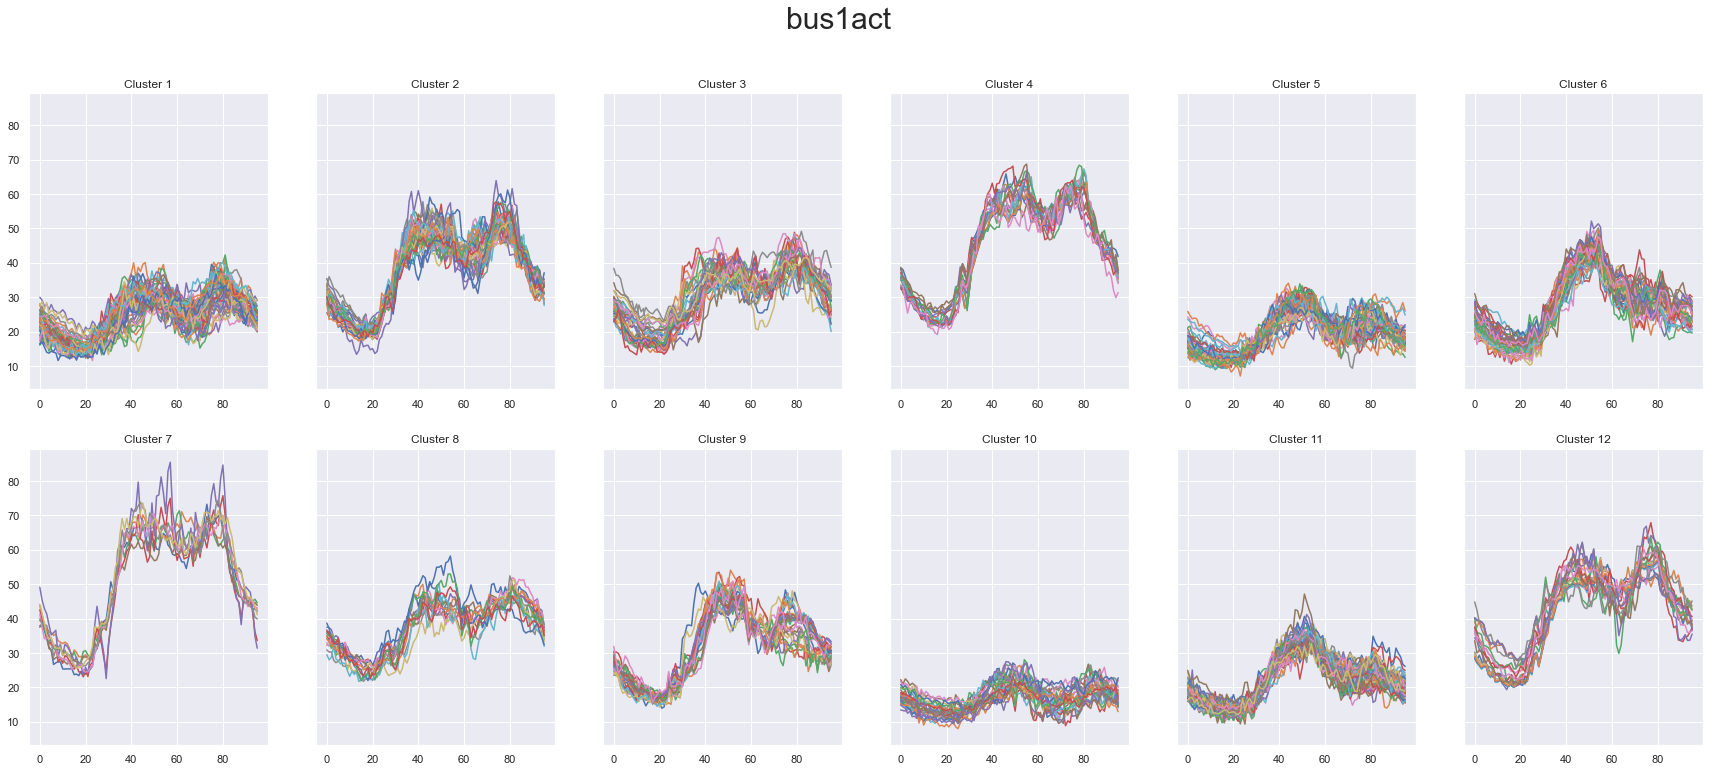

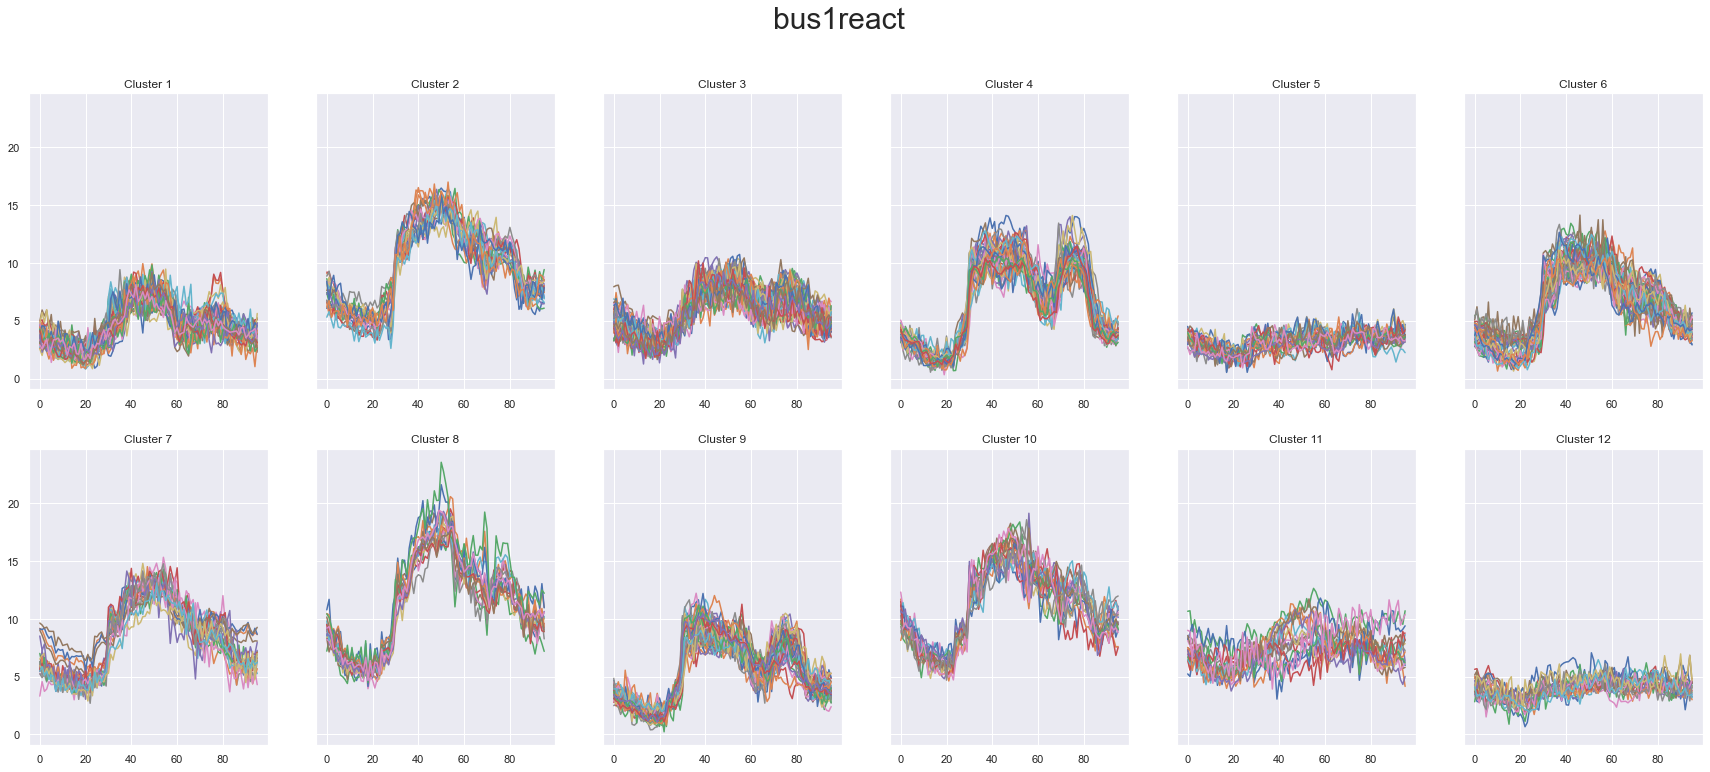

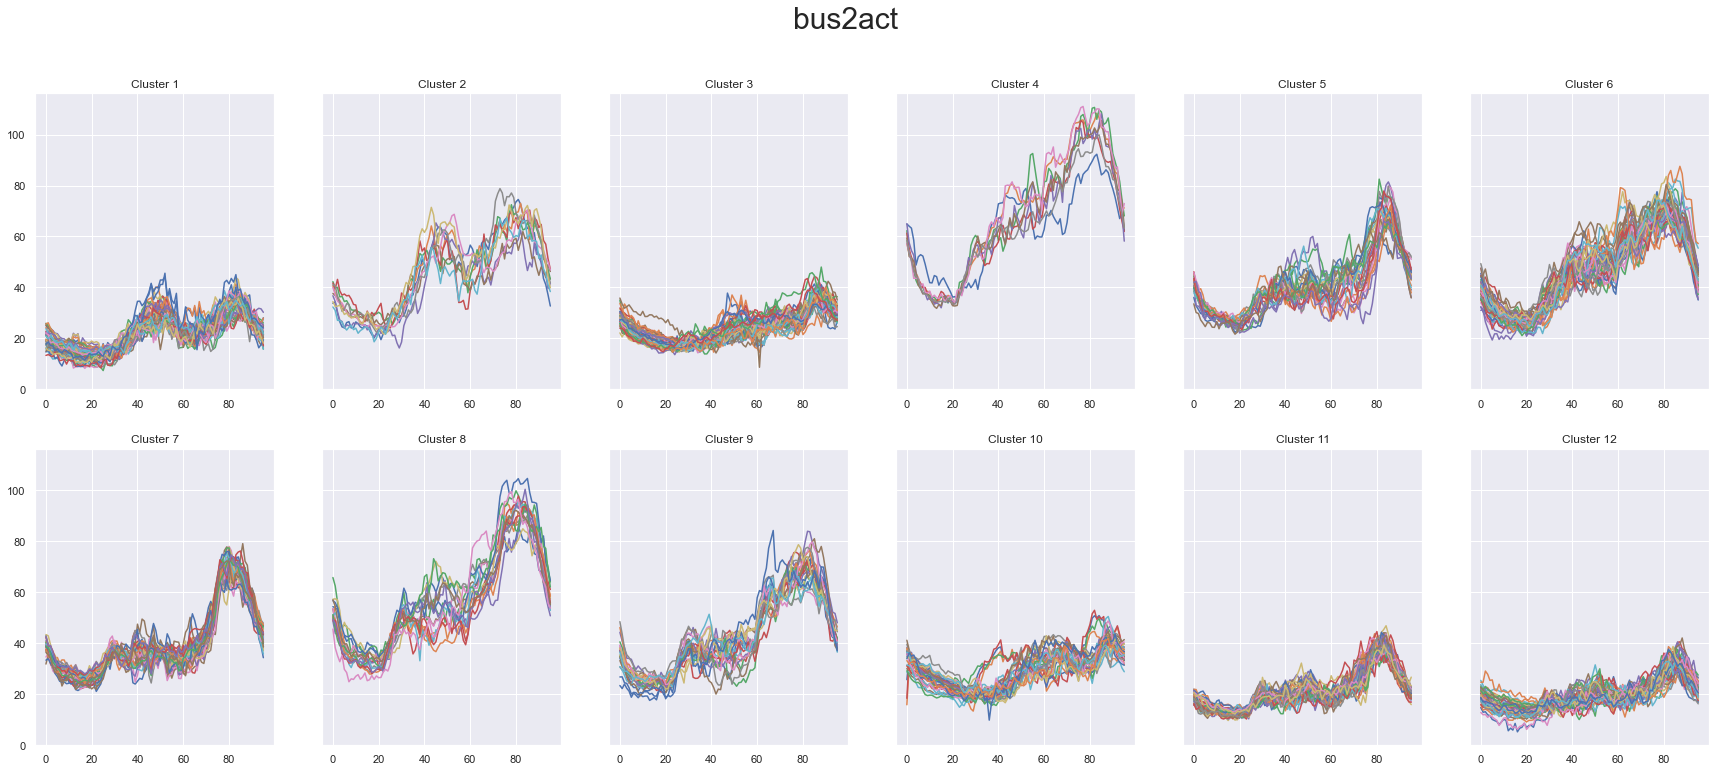

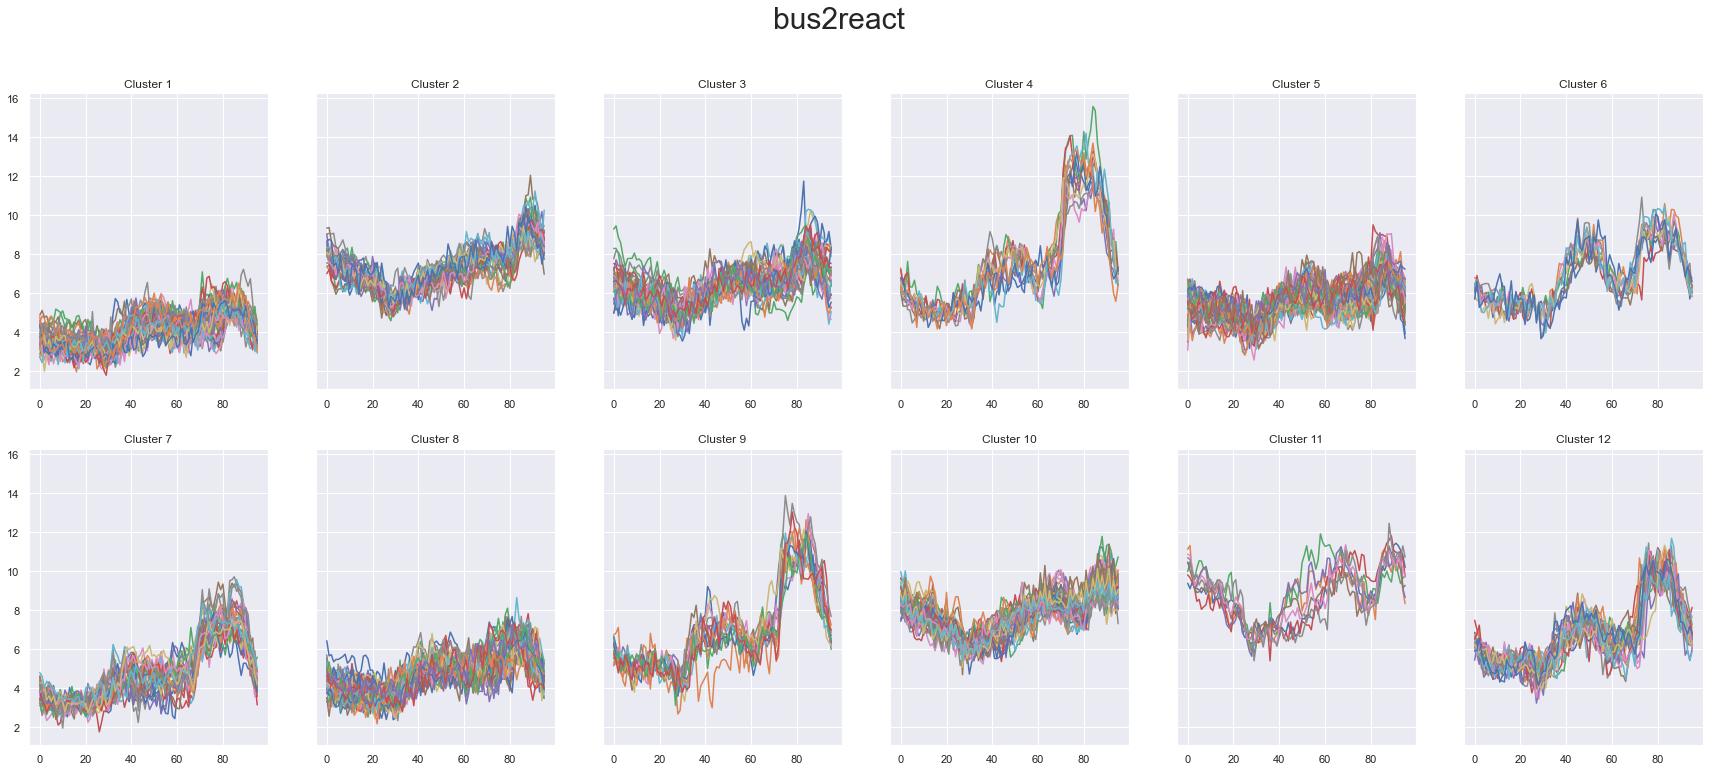

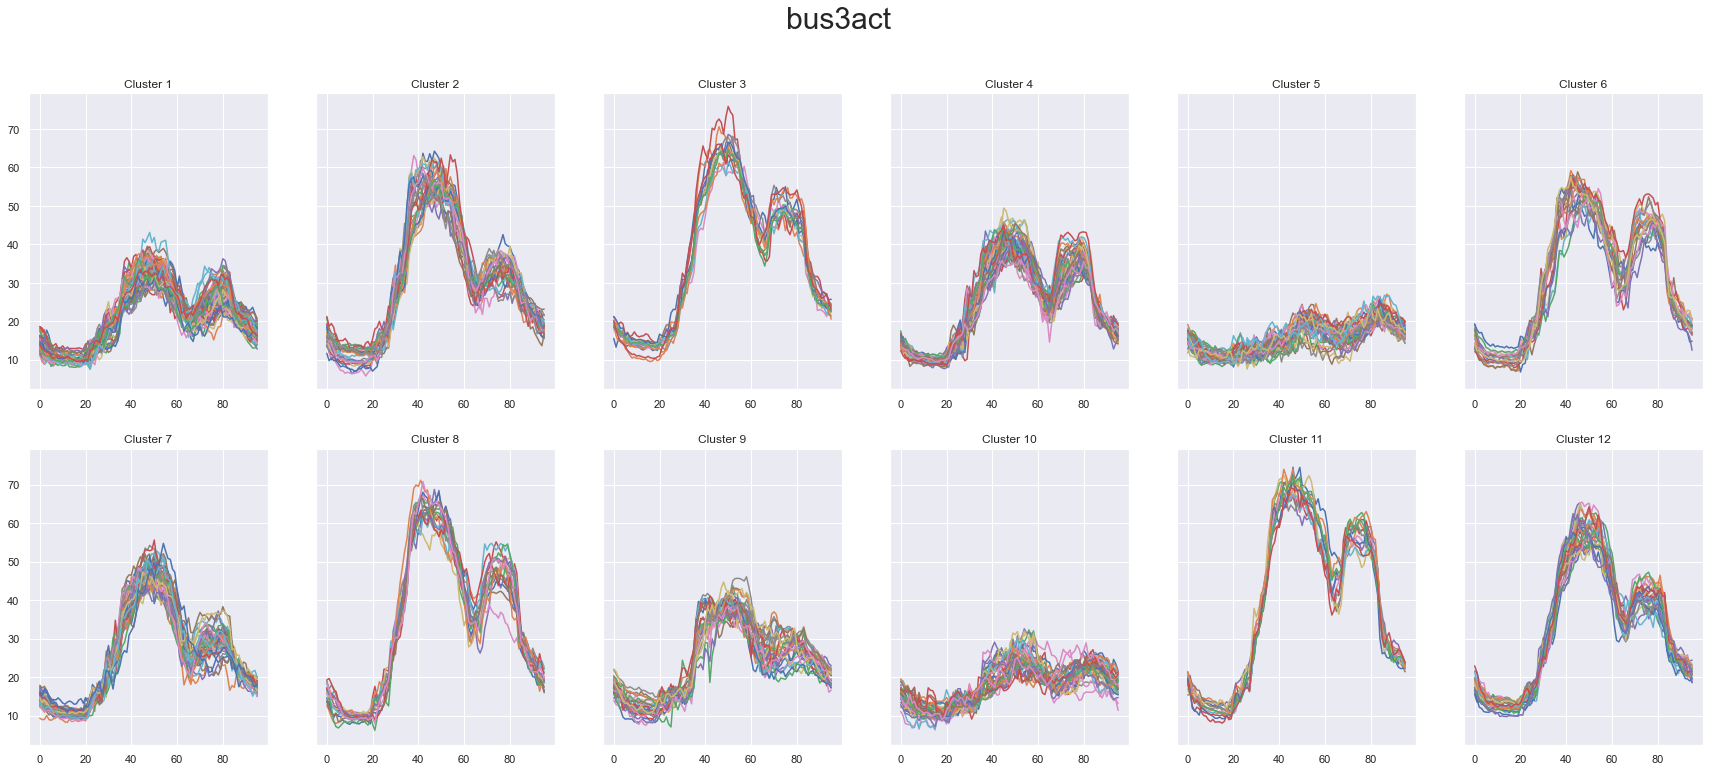

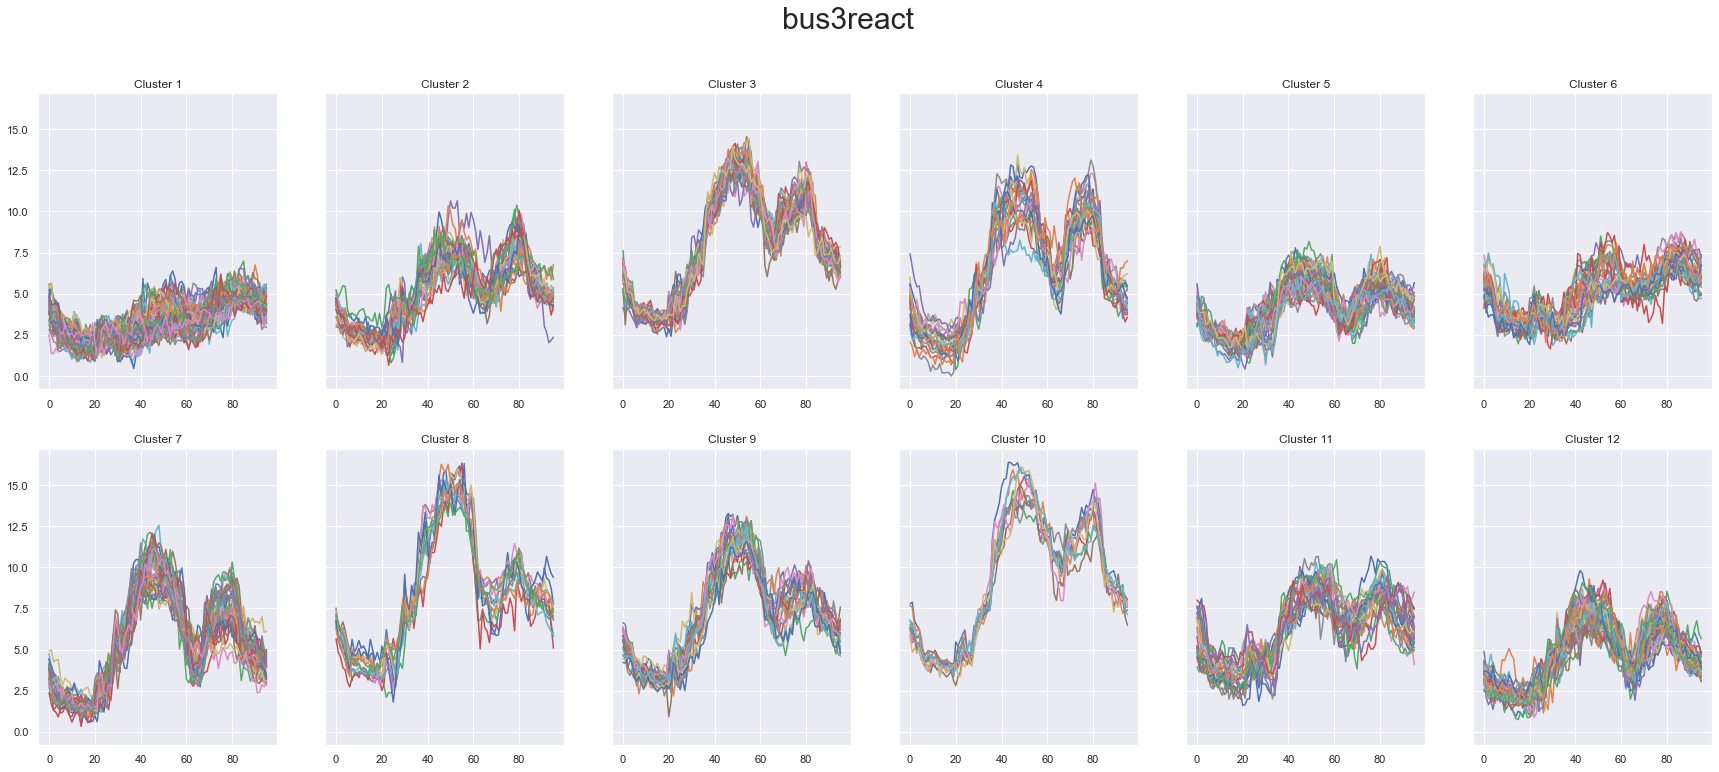

In [6]:
for key in buses.columns:
    Fu.visualization(genbuses_2_2[key], days=365, n_components=12, title = key, visual=True)